In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Load the datasets to understand their structure and content
customers_data = pd.read_excel('data/CustomersData.xlsx')
discount_coupon = pd.read_csv('data/Discount_Coupon.csv')
marketing_spend = pd.read_csv('data/Marketing_Spend.csv')
online_sales = pd.read_csv('data/Online_Sales.csv')
tax_amount = pd.read_excel('data/Tax_amount.xlsx')

# Display the first few rows of each dataset to get an overview
datasets_overview = {
    "CustomersData": customers_data.head(),
    "Discount_Coupon": discount_coupon.head(),
    "Marketing_Spend": marketing_spend.head(),
    "Online_Sales": online_sales.head(),
    "Tax_amount": tax_amount.head()
}

display('Customer Data', customers_data)
display('Discount', discount_coupon)
display('Marketing Spend', marketing_spend)
display('Tax', tax_amount)
display('Online Sales', online_sales)

'Customer Data'

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49
...,...,...,...,...
1463,14438,F,New York,41
1464,12956,F,Chicago,48
1465,15781,M,New Jersey,19
1466,14410,F,New York,45


'Discount'

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20
...,...,...,...,...
199,Nov,Notebooks & Journals,NJ20,20
200,Dec,Notebooks & Journals,NJ30,30
201,Oct,Android,AND10,10
202,Nov,Android,AND20,20


'Marketing Spend'

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30
...,...,...,...
360,12/27/2019,4000,3396.87
361,12/28/2019,4000,3246.84
362,12/29/2019,4000,2546.58
363,12/30/2019,4000,674.31


'Tax'

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18
5,Lifestyle,0.18
6,Notebooks & Journals,0.05
7,Headgear,0.05
8,Waze,0.18
9,Fun,0.18


'Online Sales'

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


## Exploratory Data Analaysis

In [3]:
online_sales = online_sales.dropna(subset=['Transaction_Date'])
online_sales[['Transaction_Date','Quantity','Avg_Price']]
online_sales['Total Sales'] = online_sales['Quantity']*online_sales['Avg_Price']
df_daily_sales =  online_sales.groupby('Transaction_Date')['Total Sales'].sum().reset_index()

fig = px.line(df_daily_sales, x='Transaction_Date', y='Total Sales', title='Daily Online Sales', height = 600)
fig.update_xaxes(title_text='Transaction Date')
fig.update_yaxes(title_text='Total Sales')
fig.show()


In [4]:
fig = px.histogram(df_daily_sales, x='Total Sales', title='Histogram of Total Sales', height = 500)
fig.update_xaxes(title_text='Total Sales')
fig.update_yaxes(title_text='Count')
fig.show()


### Outlier Removal using IQR

In [5]:
# Calculate Q1 and Q3
Q1 = df_daily_sales['Total Sales'].quantile(0.25)
Q3 = df_daily_sales['Total Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
cleaned_daily_sales = df_daily_sales[(df_daily_sales['Total Sales'] >= lower_bound) & 
                                    (df_daily_sales['Total Sales'] <= upper_bound)]

fig = px.histogram(cleaned_daily_sales, x='Total Sales', title='Histogram of Total Sales', height = 600)
fig.update_xaxes(title_text='Total Sales')
fig.update_yaxes(title_text='Count')
fig.show()


In [6]:
outlier_dates = set(df_daily_sales['Transaction_Date']) - set(cleaned_daily_sales['Transaction_Date'])

# Step 2: Filter original online_sales for transactions on outlier dates
outlier_transactions = online_sales[online_sales['Transaction_Date'].isin(outlier_dates)]

# Step 3: Output the Transaction_IDs from these transactions
outlier_transaction_ids = outlier_transactions['Transaction_ID']

# Display or output the list of Transaction_IDs
print(outlier_transaction_ids)

5486     20340
5487     20340
5488     20341
5489     20342
5490     20342
         ...  
51574    47457
51575    47457
51576    47457
51577    47457
51578    47457
Name: Transaction_ID, Length: 3336, dtype: int64


In [7]:
online_sales = online_sales[~online_sales['Transaction_ID'].isin(outlier_transaction_ids)]

## RFM Analysis

In [8]:
display(online_sales)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Total Sales
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2.05
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,87.65
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,16.50
...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,121.30
52920,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,48.92
52921,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,151.88
52922,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,402.60


In [9]:
df_recency = online_sales.groupby(by='CustomerID', 
                        as_index=False)['Transaction_Date'].max()

df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = pd.to_datetime('12/31/2019')
print(recent_date)
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - pd.to_datetime(x)).days)
df_recency.head()

2019-12-31 00:00:00


,CustomerID,LastPurchaseDate,Recency
0,12346,9/15/2019,107
1,12347,3/24/2019,282
2,12348,6/22/2019,192
3,12350,12/14/2019,17
4,12356,9/15/2019,107


In [10]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_recency.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[df_recency[col] for col in df_recency.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='Recency Data for Customers')
fig.show()

In [11]:
frequency_df = online_sales.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['Transaction_Date'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,2
1,12347,60
2,12348,23
3,12350,17
4,12356,36


In [12]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(frequency_df.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[frequency_df[col] for col in frequency_df.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='Frequency Data for Customers')
fig.show()

In [13]:
online_sales['Total'] = online_sales['Avg_Price']*online_sales['Quantity']
monetary_df = online_sales.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346,30.99
1,12347,13834.90
2,12348,1442.12
3,12350,1360.07
4,12356,1442.47


In [14]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(monetary_df.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[monetary_df[col] for col in monetary_df.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='Monetary Data for Customers')
fig.show()

In [15]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,107,2,30.99
1,12347,282,60,13834.90
2,12348,192,23,1442.12
3,12350,17,17,1360.07
4,12356,107,36,1442.47


In [16]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(rfm_df.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[rfm_df[col] for col in rfm_df.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='RFM Data for Customers')
fig.show()

In [17]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346,107,2,30.99,75.777935,6.567797,6.567797
1,12347,282,60,13834.90,14.886846,84.251412,84.251412
2,12348,192,23,1442.12,39.179632,54.096045,54.096045
3,12350,17,17,1360.07,96.570014,43.079096,43.079096
4,12356,107,36,1442.47,75.777935,68.538136,68.538136


In [18]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
	rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)


,CustomerID,RFM_Score
0,12346,0.85
1,12347,3.69
2,12348,2.59
3,12350,2.56
4,12356,3.48
5,12359,2.19
6,12370,4.22


In [19]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
									4.5, "Top Customers", 
									(np.where(
										rfm_df['RFM_Score'] > 4,
										"High value Customer",
										(np.where(
	rfm_df['RFM_Score'] > 3,
							"Medium Value Customer",
							np.where(rfm_df['RFM_Score'] > 1.6, 
							'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].sort_values(by = 'RFM_Score', ascending = False)


,CustomerID,RFM_Score,Customer_segment
619,14911,4.85,Top Customers
544,14606,4.83,Top Customers
709,15311,4.83,Top Customers
642,15039,4.82,Top Customers
553,14646,4.82,Top Customers
...,...,...,...
1095,16995,0.15,Lost Customers
652,15070,0.13,Lost Customers
1333,17925,0.13,Lost Customers
333,13747,0.11,Lost Customers


In [20]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(rfm_df.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[rfm_df[col] for col in rfm_df.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='Customer Segment Based on RFM Score')
fig.show()

In [21]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(
    labels=rfm_df.Customer_segment.value_counts().index, 
    values=rfm_df.Customer_segment.value_counts())],
    )
fig.update_layout(height=600, title='Percentage of Customer Segments based on Transaction Count') 
fig.show()

#### Marketing Spend

In [22]:
marketing_spend.describe()

,Offline_Spend,Online_Spend
count,365.000000,365.000000
mean,2843.561644,1905.880740
std,952.292448,808.856853
min,500.000000,320.250000
25%,2500.000000,1258.600000
50%,3000.000000,1881.940000
75%,3500.000000,2435.120000
max,5000.000000,4556.930000


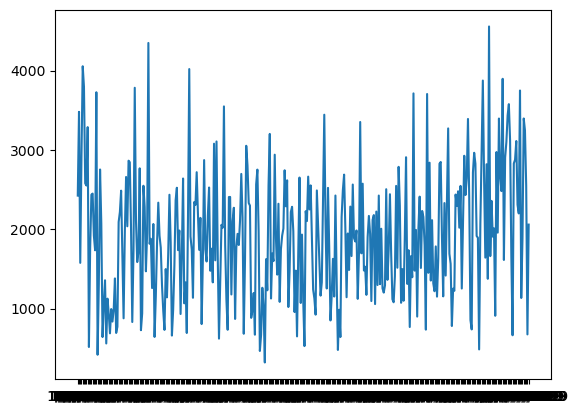

In [23]:
x = marketing_spend['Date']
y = marketing_spend['Online_Spend']
plt.plot(x,y)

### Online Sales Data

In [24]:
online_sales

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Total Sales,Total
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71,153.71
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71,153.71
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2.05,2.05
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,87.65,87.65
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,16.50,16.50
...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,121.30,121.30
52920,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,48.92,48.92
52921,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,151.88,151.88
52922,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,402.60,402.60


### Merge sales data with RFM Anaylsis

In [25]:
df_dailysales_rfm = pd.merge(online_sales, rfm_df, on='CustomerID', how='left')
df_dailysales_rfm.to_csv('dailysales_rfm.csv')
df_dailysales_rfm


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Total Sales,Total,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71,153.71,361,297,34551.40,0.92,99.65,99.65,4.24,High value Customer
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,153.71,153.71,361,297,34551.40,0.92,99.65,99.65,4.24,High value Customer
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2.05,2.05,361,297,34551.40,0.92,99.65,99.65,4.24,High value Customer
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,87.65,87.65,361,297,34551.40,0.92,99.65,99.65,4.24,High value Customer
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,16.50,16.50,361,297,34551.40,0.92,99.65,99.65,4.24,High value Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,121.30,121.30,0,8,1108.99,100.00,21.08,21.08,1.65,Low Value Customers
49584,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,48.92,48.92,0,8,1108.99,100.00,21.08,21.08,1.65,Low Value Customers
49585,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,151.88,151.88,0,8,1108.99,100.00,21.08,21.08,1.65,Low Value Customers
49586,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,402.60,402.60,0,2,724.68,100.00,6.57,6.57,1.03,Lost Customers


In [26]:
# Convert Transaction_Date to datetime format if not already
df_dailysales_rfm['Transaction_Date'] = pd.to_datetime(df_dailysales_rfm['Transaction_Date'])

# Aggregate data per month and per Customer_segment based on 'Total'
df_aggregated = df_dailysales_rfm.groupby([df_dailysales_rfm['Transaction_Date'].dt.to_period('M'), 'Customer_segment'])['Total'].sum().reset_index()

# Convert the period back to datetime (first day of each month)
df_aggregated['Transaction_Date'] = df_aggregated['Transaction_Date'].dt.to_timestamp()

# Pivot the data for plotting
df_pivot = df_aggregated.pivot(index='Transaction_Date', columns='Customer_segment', values='Total').fillna(0)

# Sort columns by the sum of their values (ascending order)
columns_sorted = df_pivot.sum().sort_values(ascending=False).index
df_pivot_sorted = df_pivot[columns_sorted]

# Plot
fig = px.bar(df_pivot_sorted, x=df_pivot_sorted.index, y=df_pivot_sorted.columns,
             title="Monthly Total Sales by Customer Segment",
             labels={'value':'Total', 'variable':'Customer Segment'},
             color_discrete_sequence=px.colors.sequential.Viridis_r, height = 800)

# Make the chart stacked
fig.update_layout(barmode='stack')

fig.show()

In [27]:
df_pivot_sorted.to_csv("monthly_sales_persegment.csv")

In [28]:
sum_per_segment = df_pivot_sorted.sum()

# Convert the series to a DataFrame
df_persegment = sum_per_segment.reset_index()
df_persegment.columns = ['Customer Segment', 'Total Sales']


In [29]:
import pandas as pd


# Average Purchase Value
#df_dailysales_rfm['Average_Purchase_Value'] = df_dailysales_rfm['Monetary'] / df_dailysales_rfm['Frequency']

# Customer Tenure (in days, assuming 'Transaction_Date' is in datetime format)
# Convert 'Transaction_Date' to datetime format
df_dailysales_rfm['Transaction_Date'] = pd.to_datetime(df_dailysales_rfm['Transaction_Date'])

# Now, calculate 'Customer_Tenure'
df_dailysales_rfm['Customer_Tenure'] = (df_dailysales_rfm['Transaction_Date'].max() - df_dailysales_rfm.groupby('CustomerID')['Transaction_Date'].transform('min')).dt.days
# Product Variety
df_dailysales_rfm['Product_Variety'] = df_dailysales_rfm.groupby('CustomerID')['Product_Category'].transform('nunique')

# These features would then be included in your X dataset for model training

# Aggregate numeric data and include Customer_segment
aggregated_data = df_dailysales_rfm.groupby('CustomerID').agg({
    'Monetary': ['sum', 'mean', 'std'], # Total, average, and std deviation of spend
    'Quantity': ['sum', 'mean'], # Total and average quantity purchased
    'Transaction_Date': ['max'], # Date of last purchase
    'Product_Category': ['nunique'], # Number of unique product categories purchased
    'Customer_segment': lambda x: x.mode()[0] if not x.mode().empty else np.nan, # Most common Customer_segment
    'Frequency' : ['max']
}).reset_index()

# Rename columns for clarity, including the Customer_segment
aggregated_data.columns = ['CustomerID', 'Total_Spend', 'Average_Spend', 'Spend_StdDev', 'Total_Quantity', 'Average_Quantity', 'Last_Purchase_Date', 'Unique_Categories', 'Customer_Segment', 'Frequency']

# Calculate Recency
current_date = df_dailysales_rfm['Transaction_Date'].max()
aggregated_data['Recency'] = (current_date - aggregated_data['Last_Purchase_Date']).dt.days

# Now 'aggregated_data' contains one record per customer with aggregated features, including Customer_Segment
aggregated_data.head()


,CustomerID,Total_Spend,Average_Spend,Spend_StdDev,Total_Quantity,Average_Quantity,Last_Purchase_Date,Unique_Categories,Customer_Segment,Frequency,Recency
0,12346,61.98,30.99,0.0,3,1.500000,2019-09-15,2,Lost Customers,2,107
1,12347,830094.00,13834.90,0.0,342,5.700000,2019-11-02,10,Medium Value Customer,60,59
2,12348,33168.76,1442.12,0.0,209,9.086957,2019-10-19,6,Low Value Customers,23,73
3,12350,23121.19,1360.07,0.0,21,1.235294,2019-12-14,4,Low Value Customers,17,17
4,12356,51928.92,1442.47,0.0,56,1.555556,2019-09-15,7,Medium Value Customer,36,107


In [30]:
import pandas as pd

# Assuming 'aggregated_data' is your DataFrame
# One-hot encode the 'Customer_Segment' column
encoded_segments = pd.get_dummies(aggregated_data['Customer_Segment'], prefix='Segment')

# Concatenate the one-hot encoded columns back to the original DataFrame
aggregated_data_encoded = pd.concat([aggregated_data, encoded_segments], axis=1)

# Optionally, you might want to drop the original 'Customer_Segment' column if it's no longer needed
# aggregated_data_encoded.drop('Customer_Segment', axis=1, inplace=True)

# Display the first few rows to verify the one-hot encoding
aggregated_data_encoded.head()


,CustomerID,Total_Spend,Average_Spend,Spend_StdDev,Total_Quantity,Average_Quantity,Last_Purchase_Date,Unique_Categories,Customer_Segment,Frequency,Recency,Segment_High value Customer,Segment_Lost Customers,Segment_Low Value Customers,Segment_Medium Value Customer,Segment_Top Customers
0,12346,61.98,30.99,0.0,3,1.500000,2019-09-15,2,Lost Customers,2,107,0,1,0,0,0
1,12347,830094.00,13834.90,0.0,342,5.700000,2019-11-02,10,Medium Value Customer,60,59,0,0,0,1,0
2,12348,33168.76,1442.12,0.0,209,9.086957,2019-10-19,6,Low Value Customers,23,73,0,0,1,0,0
3,12350,23121.19,1360.07,0.0,21,1.235294,2019-12-14,4,Low Value Customers,17,17,0,0,1,0,0
4,12356,51928.92,1442.47,0.0,56,1.555556,2019-09-15,7,Medium Value Customer,36,107,0,0,0,1,0


In [31]:
aggregated_data.describe()

,CustomerID,Total_Spend,Average_Spend,Spend_StdDev,Total_Quantity,Average_Quantity,Unique_Categories,Frequency,Recency
count,1416.000000,1.416000e+03,1416.000000,1347.0,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,15311.942090,3.009498e+05,2956.006215,0.0,149.156073,4.328267,5.995056,35.019774,148.343927
std,1741.794348,1.746339e+06,4268.922133,0.0,257.961361,6.610426,3.161715,48.564434,101.756855
min,12346.000000,1.000000e+00,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,13830.500000,6.520762e+03,633.380000,0.0,18.000000,1.400000,4.000000,9.750000,62.000000
50%,15302.500000,3.366392e+04,1696.910000,0.0,60.000000,2.377783,6.000000,20.000000,134.000000
75%,16865.500000,1.570720e+05,3801.840000,0.0,172.500000,4.852412,8.000000,44.000000,222.000000
max,18283.000000,4.024290e+07,61345.880000,0.0,4196.000000,103.000000,19.000000,656.000000,364.000000


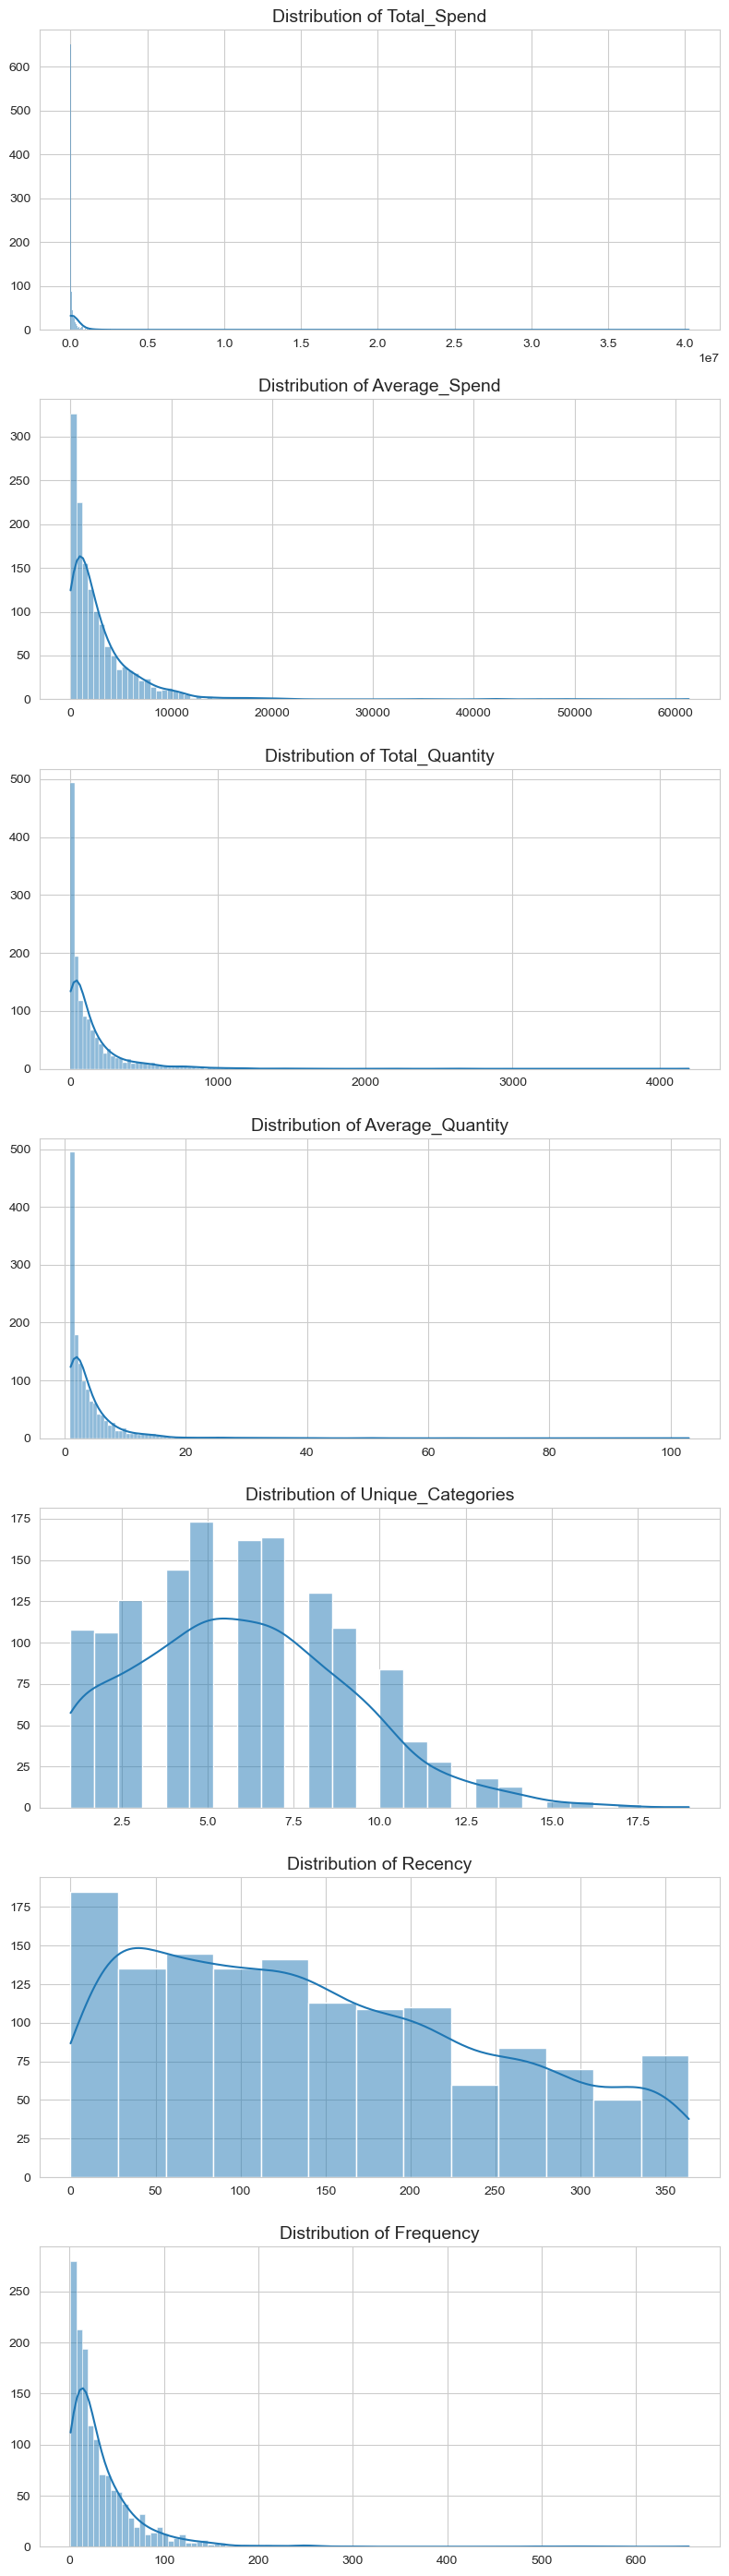

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of numeric features to analyze
numeric_features = ['Total_Spend', 'Average_Spend', 'Total_Quantity', 'Average_Quantity', 'Unique_Categories','Recency', 'Frequency']

# Plot distribution of numeric features
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 4 * len(numeric_features)))
for i, col in enumerate(numeric_features):
    sns.histplot(aggregated_data[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


In [33]:
import plotly.express as px
import pandas as pd

# Assuming 'aggregated_data' is your DataFrame with a 'Customer_Segment' column

# Count the occurrences of each Customer Segment and sort
segment_counts = aggregated_data['Customer_Segment'].value_counts().reset_index()
segment_counts.columns = ['Customer_Segment', 'Counts']

# Now, segment_counts is sorted by the count in descending order
# To sort ascending, use: segment_counts.sort_values('Counts', ascending=True, inplace=True)

# Plot the distribution of Customer Segments using Plotly, with the sorted data
fig = px.bar(segment_counts, 
             x='Customer_Segment', 
             y='Counts',
             title='Distribution of Customer Segments',
             color='Customer_Segment',  # This will assign a different color to each bar
             )

# Update the layout for a more refined look and set the height
fig.update_layout(
    xaxis_title="Customer Segment",
    yaxis_title="Count",
    xaxis_tickangle=-45,  # Rotate the labels for better readability
    title={
        'text': "Distribution of Customer Segments",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="RebeccaPurple"
    ),
    height=600  # Set the height of the plot
)

# Show the plot
fig.show()


['Total_Spend', 'Average_Spend', 'Total_Quantity', 'Average_Quantity', 'Unique_Categories', 'Recency', 'Frequency']


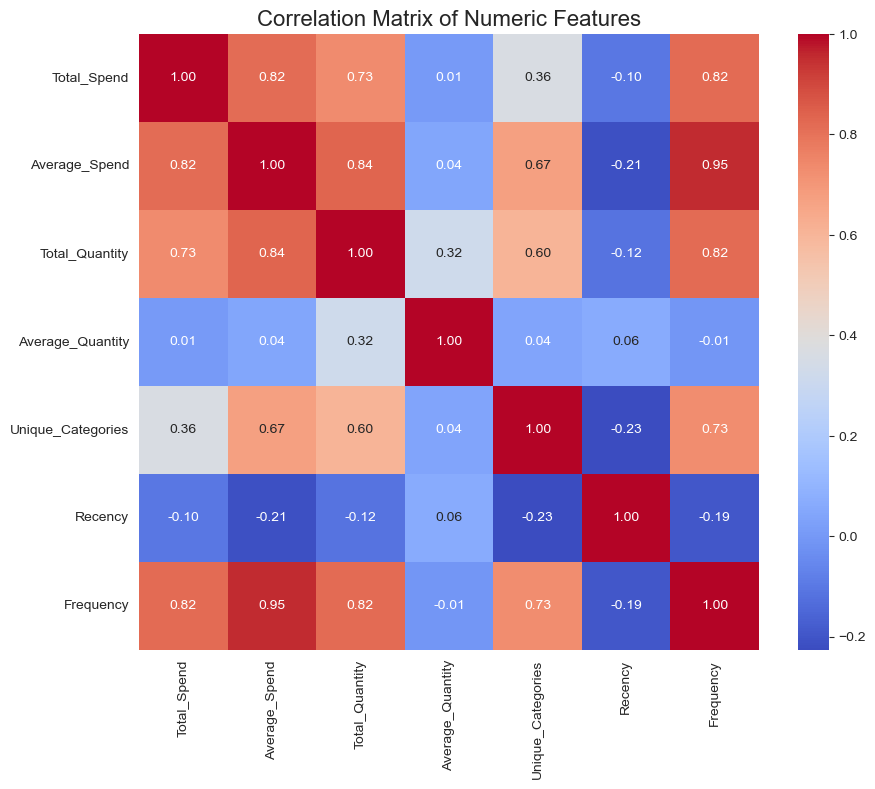

In [34]:
# Calculate correlation matrix
corr_matrix = aggregated_data[numeric_features].corr()
print(numeric_features)
# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()


['Total_Spend', 'Total_Quantity', 'Average_Quantity', 'Unique_Categories', 'Recency', 'Frequency']


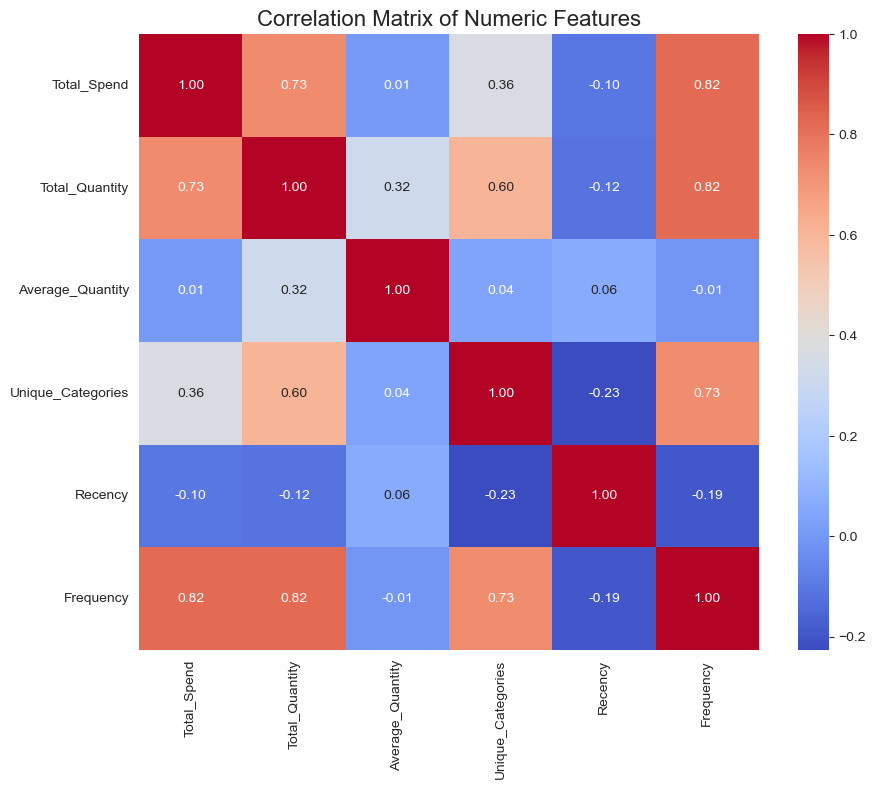

In [35]:
# Remove highly correlated Average_Spend
aggregated_data = aggregated_data.drop('Average_Spend', axis=1)
numeric_features = ['Total_Spend', 'Total_Quantity', 'Average_Quantity', 'Unique_Categories','Recency', 'Frequency']

corr_matrix = aggregated_data[numeric_features].corr()
print(numeric_features)
# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()


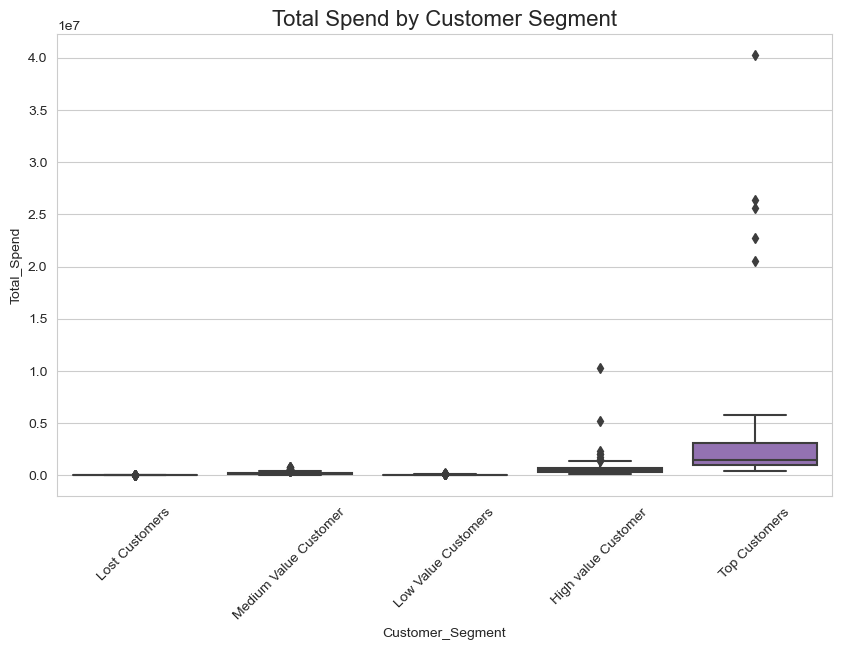

In [36]:
# Example: Boxplot of Total_Spend across different Customer Segments
plt.figure(figsize=(10, 6))
sns.boxplot(data=aggregated_data, x='Customer_Segment', y='Total_Spend')
plt.title('Total Spend by Customer Segment', fontsize=16)
plt.xticks(rotation=45)
plt.show()


In [37]:
aggregated_data

,CustomerID,Total_Spend,Spend_StdDev,Total_Quantity,Average_Quantity,Last_Purchase_Date,Unique_Categories,Customer_Segment,Frequency,Recency
0,12346,61.98,0.0,3,1.500000,2019-09-15,2,Lost Customers,2,107
1,12347,830094.00,0.0,342,5.700000,2019-11-02,10,Medium Value Customer,60,59
2,12348,33168.76,0.0,209,9.086957,2019-10-19,6,Low Value Customers,23,73
3,12350,23121.19,0.0,21,1.235294,2019-12-14,4,Low Value Customers,17,17
4,12356,51928.92,0.0,56,1.555556,2019-09-15,7,Medium Value Customer,36,107
...,...,...,...,...,...,...,...,...,...,...
1411,18256,198.24,0.0,4,1.000000,2019-07-05,2,Lost Customers,4,179
1412,18260,94522.00,0.0,141,3.525000,2019-10-05,11,Medium Value Customer,40,87
1413,18269,14.69,NaN,1,1.000000,2019-06-20,1,Lost Customers,1,194
1414,18277,298.00,NaN,2,2.000000,2019-10-23,1,Lost Customers,1,69


In [38]:
# Assuming 'aggregated_data' is your DataFrame
features_to_drop = ['CustomerID', 'Last_Purchase_Date',	'Spend_StdDev']  # Add any non-numeric or identifier columns here
data_for_modeling = aggregated_data.drop(features_to_drop, axis=1)
data_for_modeling.describe()

,Total_Spend,Total_Quantity,Average_Quantity,Unique_Categories,Frequency,Recency
count,1.416000e+03,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,3.009498e+05,149.156073,4.328267,5.995056,35.019774,148.343927
std,1.746339e+06,257.961361,6.610426,3.161715,48.564434,101.756855
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,0.000000
25%,6.520762e+03,18.000000,1.400000,4.000000,9.750000,62.000000
50%,3.366392e+04,60.000000,2.377783,6.000000,20.000000,134.000000
75%,1.570720e+05,172.500000,4.852412,8.000000,44.000000,222.000000
max,4.024290e+07,4196.000000,103.000000,19.000000,656.000000,364.000000


In [39]:
from sklearn.preprocessing import StandardScaler
X = data_for_modeling.drop(['Customer_Segment'], axis=1)  # All features except the target
y = data_for_modeling['Customer_Segment']  # Target variable

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# If you want to convert it back to a DataFrame:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df

,Total_Spend,Total_Quantity,Average_Quantity,Unique_Categories,Frequency,Recency
0,-0.172357,-0.566781,-0.428001,-1.264019,-0.680157,-0.406445
1,0.303109,0.747833,0.207584,1.267147,0.514555,-0.878324
2,-0.153393,0.232070,0.720131,0.001564,-0.247589,-0.740693
3,-0.159148,-0.496979,-0.468058,-0.631227,-0.371180,-1.291218
4,-0.142646,-0.361252,-0.419593,0.317960,0.020191,-0.406445
...,...,...,...,...,...,...
1411,-0.172279,-0.562904,-0.503665,-1.264019,-0.638960,0.301374
1412,-0.118248,-0.031629,-0.121558,1.583543,0.102585,-0.603061
1413,-0.172384,-0.574537,-0.503665,-1.580415,-0.700755,0.448837
1414,-0.172222,-0.570659,-0.352336,-1.580415,-0.700755,-0.780016


In [40]:
X_scaled_df.describe()

,Total_Spend,Total_Quantity,Average_Quantity,Unique_Categories,Frequency,Recency
count,1.416000e+03,1.416000e+03,1.416000e+03,1.416000e+03,1.416000e+03,1.416000e+03
mean,-2.383530e-17,-5.896100e-17,-5.394304e-17,7.276038e-17,5.143406e-17,1.204310e-16
std,1.000353e+00,1.000353e+00,1.000353e+00,1.000353e+00,1.000353e+00,1.000353e+00
min,-1.723921e-01,-5.745373e-01,-5.036654e-01,-1.580415e+00,-7.007555e-01,-1.458342e+00
25%,-1.686574e-01,-5.086126e-01,-4.431335e-01,-6.312275e-01,-5.205188e-01,-8.488316e-01
50%,-1.531090e-01,-3.457400e-01,-2.951659e-01,1.564103e-03,-3.093844e-01,-1.410126e-01
75%,-8.241733e-02,9.052586e-02,7.931872e-02,6.343557e-01,1.849790e-01,7.240996e-01
max,2.287990e+01,1.569333e+01,1.493196e+01,4.114709e+00,1.279125e+01,2.120076e+00


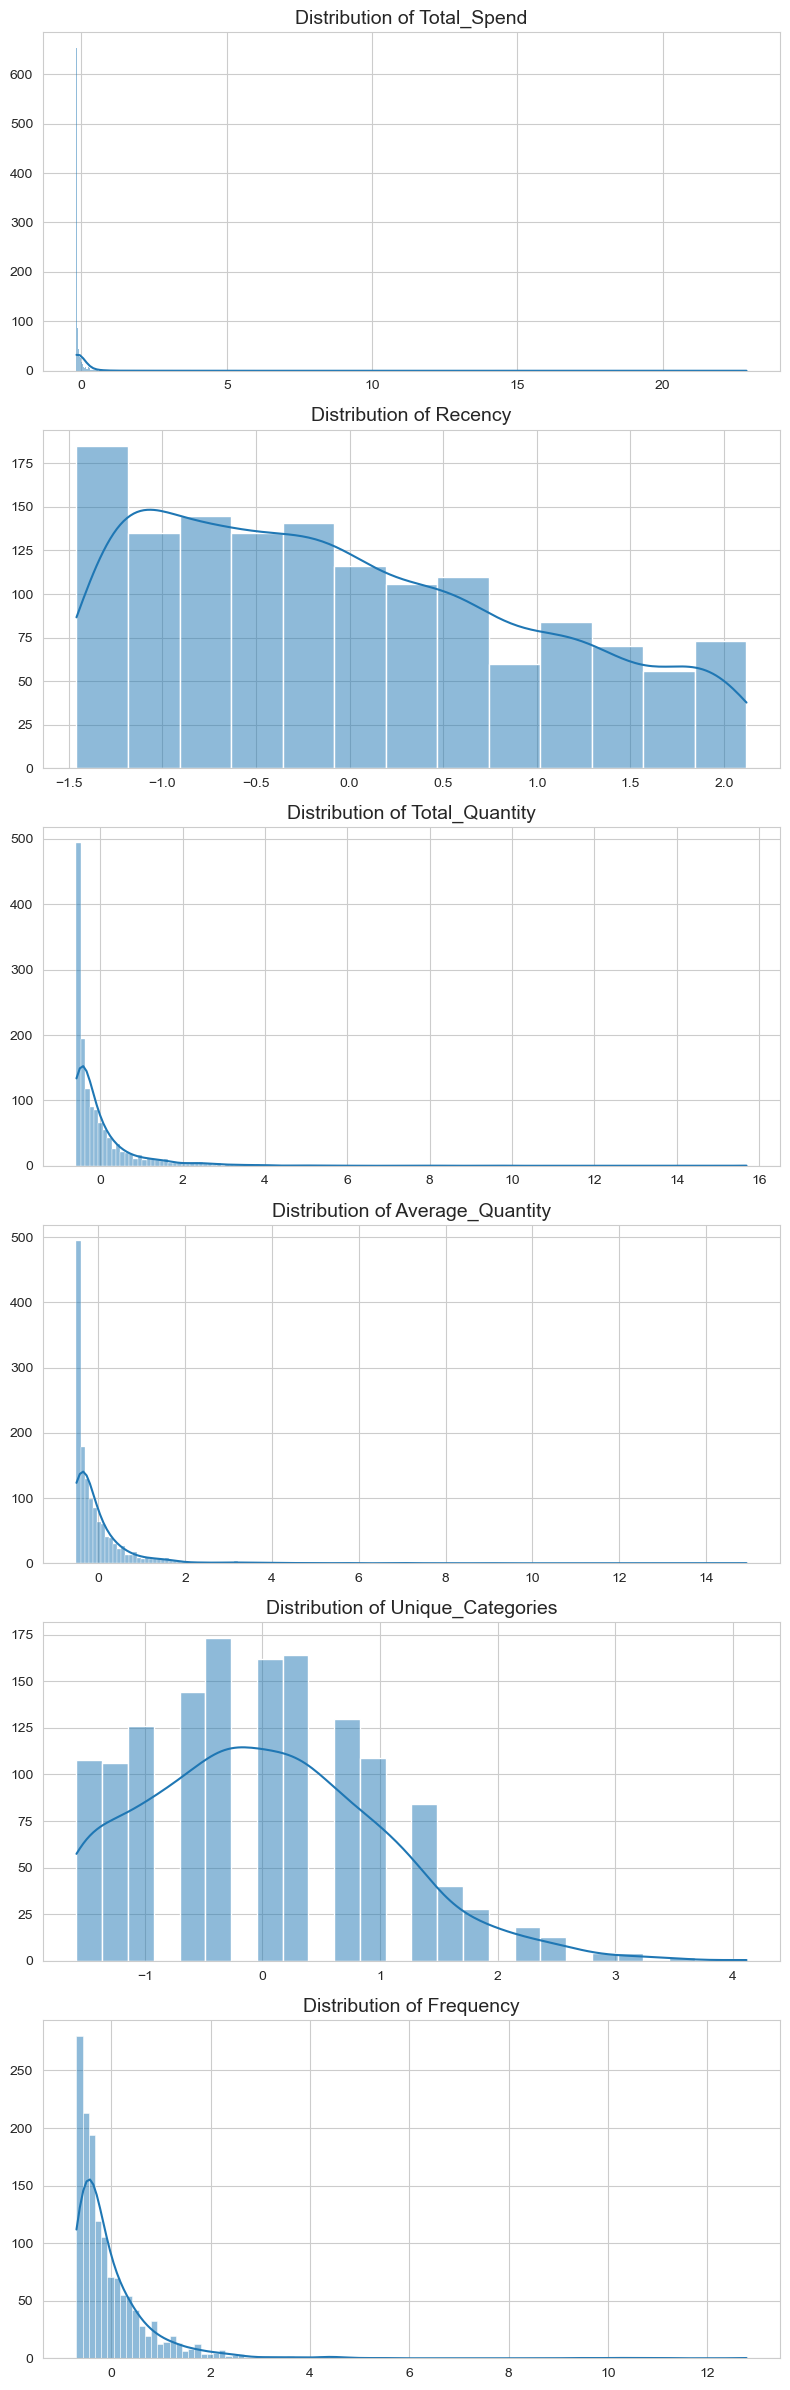

In [41]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of numeric features to analyze
numeric_features = ['Total_Spend', 'Recency', 'Total_Quantity', 'Average_Quantity', 'Unique_Categories','Frequency']

# Plot distribution of numeric features
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 4 * len(numeric_features)))
for i, col in enumerate(numeric_features):
    sns.histplot(X_scaled_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


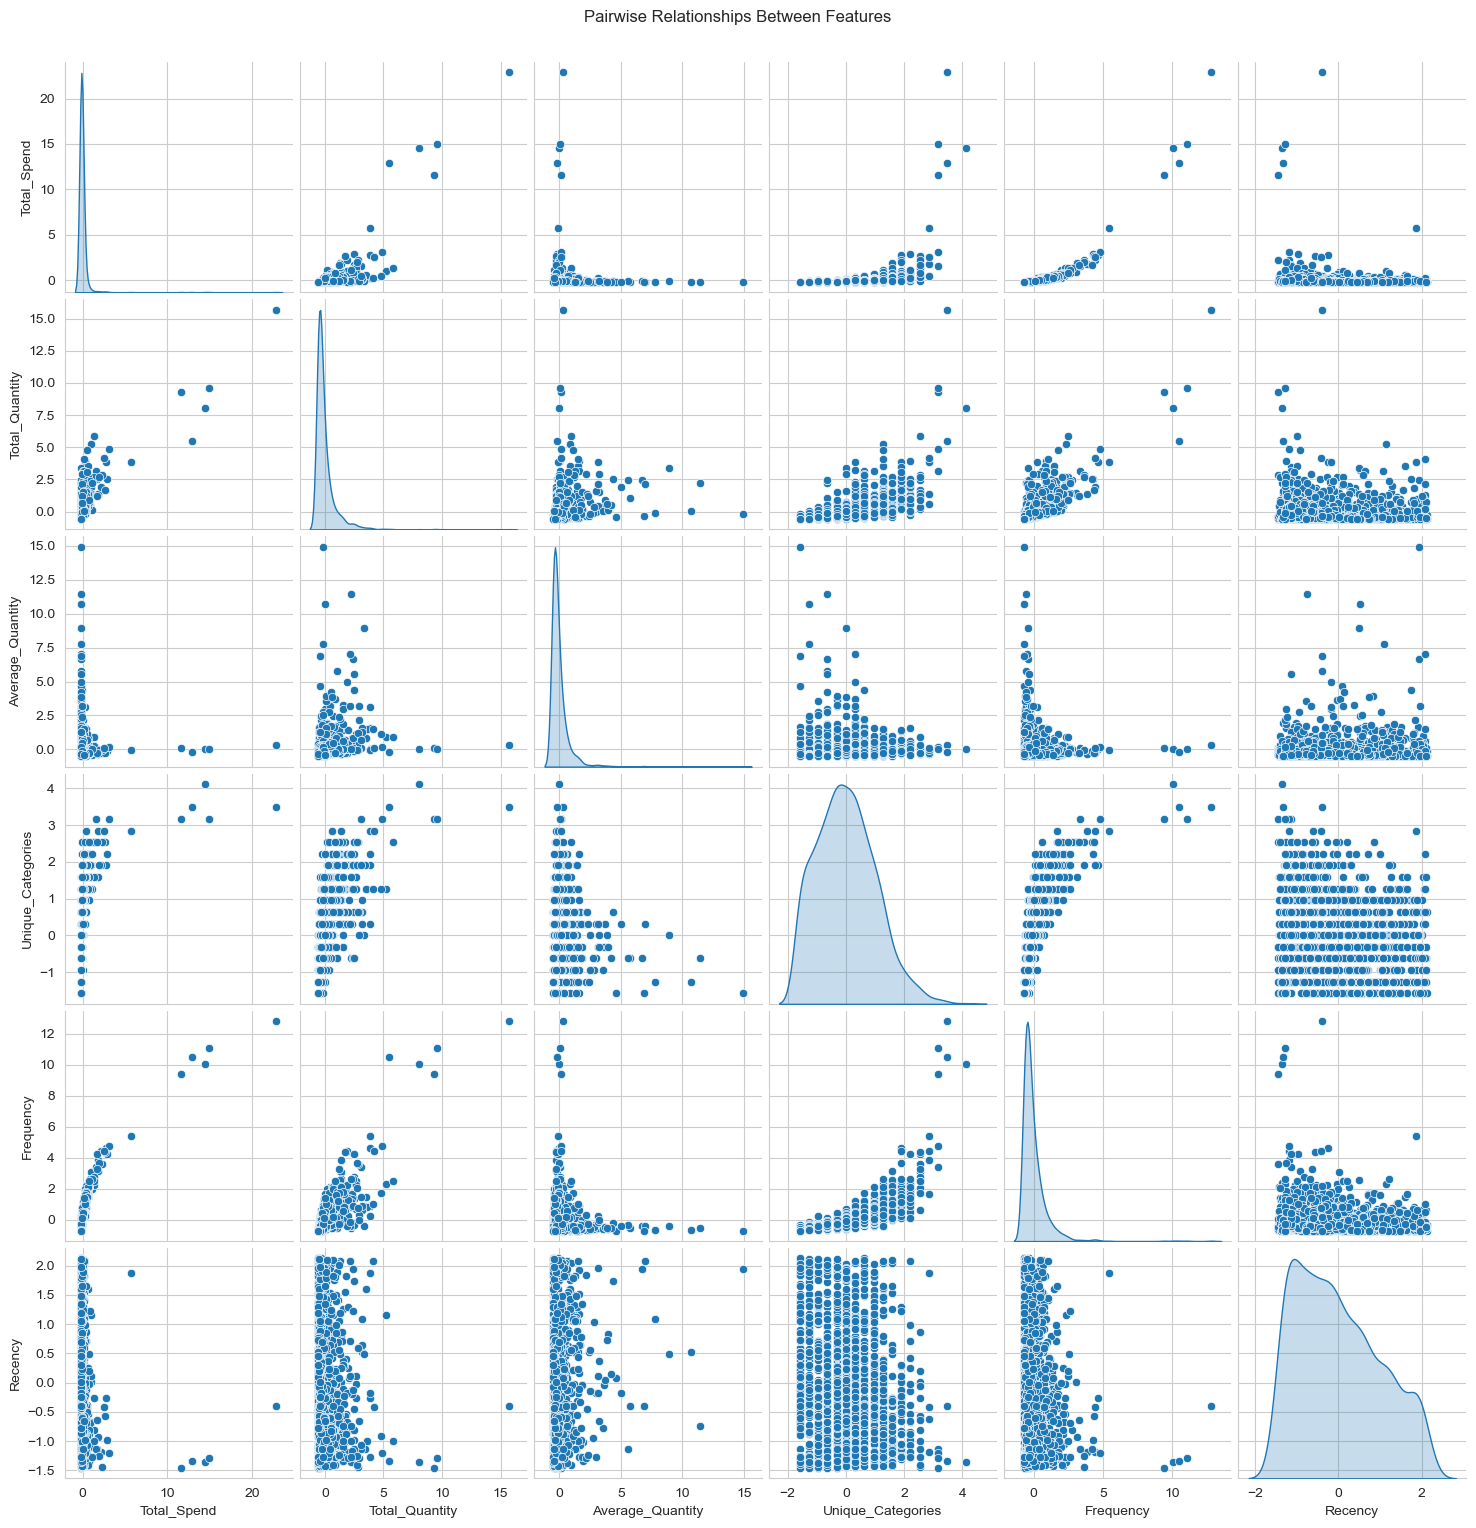

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.api.types import CategoricalDtype

# Suppress specific warnings from pandas regarding deprecation
warnings.filterwarnings('ignore', message='is_categorical_dtype is deprecated')

sns.set_style("whitegrid")

# Assuming X_scaled_df is your DataFrame
# Create a pairplot
pairplot = sns.pairplot(X_scaled_df, palette='viridis', diag_kind='kde', markers='o')

# Enhance readability
pairplot.fig.suptitle("Pairwise Relationships Between Features", y=1.02)  # Adjust title and its position
plt.show()

# Re-enable warnings if you prefer
warnings.filterwarnings('default', message='is_categorical_dtype is deprecated')


In [43]:
from sklearn.model_selection import train_test_split

y = aggregated_data['Customer_Segment']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [45]:
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.9084507042253521
                       precision    recall  f1-score   support

  High value Customer       0.64      0.53      0.58        17
       Lost Customers       0.98      0.99      0.98        85
  Low Value Customers       0.95      0.92      0.94       106
Medium Value Customer       0.88      0.91      0.89        64
        Top Customers       0.60      0.75      0.67        12

             accuracy                           0.91       284
            macro avg       0.81      0.82      0.81       284
         weighted avg       0.91      0.91      0.91       284



In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Number_trials=10

def train_random_forest(X, y):
    score_train = []
    score_test = []
    weight_coeffs = []
    max_depth_values = np.array(range(3, 10))
    
    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=seed)
        train_acc = []
        test_acc = []
        for max_depth in max_depth_values:        
            forest = RandomForestClassifier(n_estimators=100, max_features=.7, max_depth=max_depth, random_state=2)
            forest.fit(X_train, y_train)
            train_acc.append(forest.score(X_train, y_train))
            test_acc.append(forest.score(X_test, y_test))
            coeffs = forest.feature_importances_
            weight_coeffs.append(coeffs)
            
        score_train.append(train_acc)
        score_test.append(test_acc)
    
    mean_coefs=np.mean(weight_coeffs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title('Feature Importance for Random Forest')
    run_time = (time.time() - start_time)
    df_coefs = pd.DataFrame({
        'Index': X.columns[np.argsort(abs_mean_coefs)],
        'Coefficients': sorted(abs_mean_coefs)
    })

    df_coefs.to_csv('random_forest.csv')
    return ['Random Forest', np.amax(score),np.amax(train_score),\
            'Max_depth = {0}'.format(max_depth_values[np.argmax(score)]), top_predictor,run_time]

def train_gradient_boosting_method(X, y):
    score_train = []
    score_test = []
    weight_coeffs = []
    # max_depth_values = np.array(range(3, 10))
    max_features =[0.1, .2, .3, .4, .5, .7, .8, .9, 1.0]
    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=seed)
        train_acc = []
        test_acc = []
        for max_feature in max_features:
            gbrt = GradientBoostingClassifier(n_estimators =500, max_depth = 8, max_features = max_feature, learning_rate=0.1, random_state=0)
            gbrt.fit(X_train, y_train)
            train_acc.append(gbrt.score(X_train, y_train))
            test_acc.append(gbrt.score(X_test, y_test))
            coeffs = gbrt.feature_importances_
            weight_coeffs.append(coeffs)
            
        score_train.append(train_acc)
        score_test.append(test_acc)
    
    mean_coefs=np.mean(weight_coeffs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.title('Feature Importance for Gradient Boosting Method')
    run_time = (time.time() - start_time)
    df_coefs = pd.DataFrame({
        'Index': X.columns[np.argsort(abs_mean_coefs)],
        'Coefficients': sorted(abs_mean_coefs)
    })

    df_coefs.to_csv('feature_gbm.csv')
    return ['Gradient Boosting Method', np.amax(score), \
            'Max_Feature= {0}'.format(max_features[np.argmax(score)]), top_predictor,run_time]
    

['Random Forest', 0.9211764705882353, 0.991120080726539, 'Max_depth = 9', 'Frequency', 8.236377239227295]
Frequency seconds
['Gradient Boosting Method', 0.9110169491525422, 'Max_Feature= 0.9', 'Frequency', 188.39023399353027]
188.39023399353027 seconds


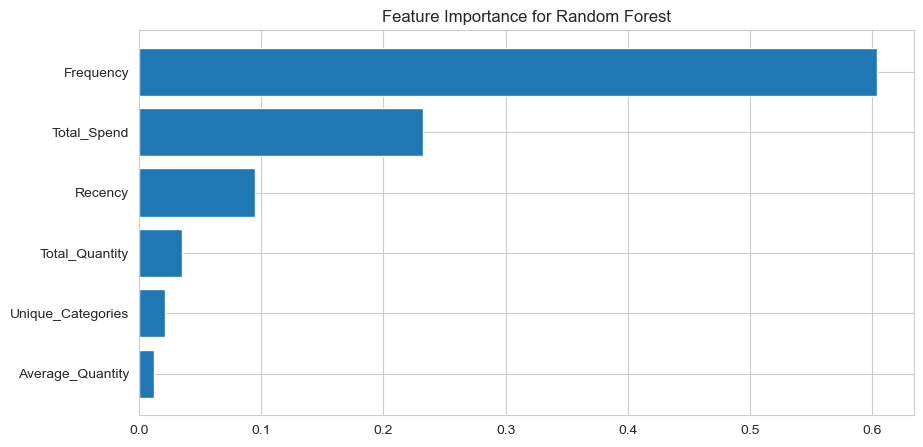

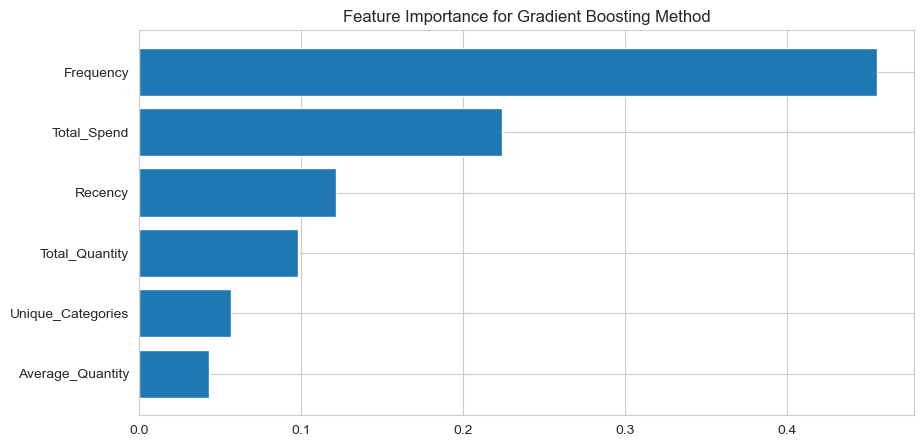

In [55]:
import time
X = X_scaled_df
start_time = time.time()
f = train_random_forest(X,y)
print(f)
print("%s seconds" % f[4])

start_time = time.time()
g = train_gradient_boosting_method(X,y)
print(g)
print("%s seconds" % g[4])

In [48]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = f
df2.loc[1] = g


df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Random Forest,0.919492,Max_depth = 7,Frequency,8.515271
1,Gradient Boosting Method,0.911017,Max_Feature= 0.9,Frequency,184.420651


In [49]:
# Creating a Plotly Table with a light blue header
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df2.columns),
                fill_color='lightblue',  # Change header fill color to light blue
                align='left'),
    cells=dict(values=[df2[col] for col in df2.columns],
               fill_color='lavender',
               align='left'))
])

# Updating layout for a cleaner look
fig.update_layout(title='Customer Segment Based on RFM Score')
fig.show()